# Projeto OLIST - DATA SCIENTIST 

Robson Müller 

Consideremos que durante o processo de entendimento do negócio e problemas a serem resolvidos, tenha surgido a necessidade de criar algo para ajudar o time de Marketing a lidar com os clientes insatisfeitos. 

Assim criamos um modelo de árvore de decisão para prever o Score Review dos clientes que ainda não receberam seus produtos e ajudar o time de marketing à se antecipar em ações com estes clientes. 



In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime
from sklearn.tree import DecisionTreeClassifier

In [56]:
df_raw = pd.read_csv('df_full.csv')

In [369]:
#df_raw.dtypes

In [292]:
df = df_raw[['review_score',
             'order_status',
             'order_purchase_timestamp',
             'order_approved_at',
             'order_delivered_carrier_date',
             'order_delivered_customer_date',
             'order_estimated_delivery_date',
             'price',
             'seller_id',
             'product_id',
             'freight_value',
             'payment_type',
             'payment_installments',
             'payment_value',
             'product_category_name',
             'product_weight_g',
             'seller_zip_code_prefix',
             'customer_zip_code_prefix']]

In [293]:
#df.head()

Vamos checar a distribuição dos valores nulos e remove-los

In [294]:
#msno.matrix(df)

In [295]:
df.dropna(inplace=True)
df.shape

/Users/robsonmuller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(114073, 18)

In [296]:
#df.dtypes

Aqui vamos converter os campos de data do formato string para data e então para o formato numero. O modelo de árvore de decisão trabalha apenas com números

In [297]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'],format='%Y-%m-%d')
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'],format='%Y-%m-%d')
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'],format='%Y-%m-%d')
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'],format='%Y-%m-%d')
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'],format='%Y-%m-%d')



/Users/robsonmuller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/robsonmuller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/robsonmuller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [298]:
df['order_purchase_timestamp'] = pd.to_timedelta(df.order_purchase_timestamp).dt.total_seconds().astype(int)
df['order_approved_at'] = pd.to_timedelta(df.order_approved_at).dt.total_seconds().astype(int)
df['order_delivered_carrier_date'] = pd.to_timedelta(df.order_delivered_carrier_date).dt.total_seconds().astype(int)
df['order_delivered_customer_date'] = pd.to_timedelta(df.order_delivered_customer_date).dt.total_seconds().astype(int)
df['order_estimated_delivery_date'] = pd.to_timedelta(df.order_estimated_delivery_date).dt.total_seconds().astype(int)

/Users/robsonmuller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/robsonmuller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/robsonmuller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [299]:
df.dtypes

review_score                       int64
order_status                      object
order_purchase_timestamp           int64
order_approved_at                  int64
order_delivered_carrier_date       int64
order_delivered_customer_date      int64
order_estimated_delivery_date      int64
price                            float64
seller_id                         object
product_id                        object
freight_value                    float64
payment_type                      object
payment_installments             float64
payment_value                    float64
product_category_name             object
product_weight_g                 float64
seller_zip_code_prefix           float64
customer_zip_code_prefix           int64
dtype: object

Temos o campo ID do Vendedor e Produto que estão em hexadecimal, vamos converte-los para número também. Com a função ID_t_n

In [300]:
seller_id = df['seller_id'].values
product_id = df['product_id'].values

In [301]:
def id_to_n(array):
    new_array = []
    for x in array:
        new_array.append(int(x,16))
    return new_array   

In [302]:
id_seller_novo = id_to_n(seller_id)
id_product_novo = id_to_n(product_id)

In [303]:
df['seller_id'] = id_seller_novo
df['product_id'] = id_product_novo

/Users/robsonmuller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/robsonmuller/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Existem campos com informação categoria. Vamos converter para n tbm 

In [304]:
df['product_category_name'].unique()

array(['esporte_lazer', 'informatica_acessorios', 'ferramentas_jardim',
       'cama_mesa_banho', 'brinquedos', 'casa_conforto',
       'eletroportateis', 'beleza_saude', 'pet_shop', 'cool_stuff',
       'eletronicos', 'bebes', 'utilidades_domesticas',
       'relogios_presentes', 'automotivo', 'telefonia',
       'fashion_bolsas_e_acessorios', 'perfumaria', 'moveis_decoracao',
       'eletrodomesticos_2', 'alimentos_bebidas', 'instrumentos_musicais',
       'papelaria', 'livros_importados', 'moveis_escritorio',
       'livros_interesse_geral', 'construcao_ferramentas_construcao',
       'livros_tecnicos', 'construcao_ferramentas_seguranca', 'artes',
       'eletrodomesticos', 'pcs', 'artigos_de_natal', 'audio',
       'industria_comercio_e_negocios', 'moveis_sala', 'consoles_games',
       'malas_acessorios', 'market_place', 'bebidas',
       'moveis_cozinha_area_de_servico_jantar_e_jardim', 'musica',
       'moveis_quarto', 'la_cuisine', 'sinalizacao_e_seguranca',
       'casa_constr

In [70]:
df['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card'], dtype=object)

In [645]:
#df.dtypes

In [652]:
X = df[['order_purchase_timestamp','order_approved_at','order_delivered_carrier_date',
        'order_estimated_delivery_date','price','seller_id','product_id',
        'freight_value','payment_type','payment_installments','product_category_name',
        'product_weight_g','seller_zip_code_prefix','customer_zip_code_prefix']].values

In [653]:
X[:5]

array([[1515684649, 1515685679, 1515794242, 1517529600, 185.0,
        145551697030293782800000111409286591431,
        336490275562023559799115339444996672723, 13.63, 'credit_card',
        8.0, 'esporte_lazer', 1300.0, 14600.0, 6030],
       [1515684649, 1515685679, 1515794242, 1517529600, 185.0,
        145551697030293782800000111409286591431,
        336490275562023559799115339444996672723, 13.63, 'credit_card',
        8.0, 'esporte_lazer', 1300.0, 14600.0, 6030],
       [1519820719, 1519822119, 1520017695, 1520985600, 79.79,
        189318756079282413887720390250287439546,
        252624667949583060400269425777759266620, 8.3, 'credit_card', 1.0,
        'informatica_acessorios', 245.0, 12233.0, 13380],
       [1517651782, 1517654021, 1517933908, 1520553600, 149.0,
        214027687101649138603710608903869557576,
        278827132795777292761669796302029793988, 45.12, 'credit_card',
        1.0, 'informatica_acessorios', 6550.0, 37175.0, 44571],
       [1491759673, 1491760519, 149

In [654]:
from sklearn import preprocessing
le_pay = preprocessing.LabelEncoder()
le_pay.fit(['credit_card', 'boleto', 'voucher','debit_card'])
X[:,8] = le_pay.transform(X[:,8])

le_prod = preprocessing.LabelEncoder()
le_prod.fit(['esporte_lazer', 'informatica_acessorios', 'ferramentas_jardim',
       'cama_mesa_banho', 'brinquedos', 'casa_conforto',
       'eletroportateis', 'beleza_saude', 'pet_shop', 'cool_stuff',
       'eletronicos', 'bebes', 'utilidades_domesticas',
       'relogios_presentes', 'automotivo', 'telefonia',
       'fashion_bolsas_e_acessorios', 'perfumaria', 'moveis_decoracao',
       'eletrodomesticos_2', 'alimentos_bebidas', 'instrumentos_musicais',
       'papelaria', 'livros_importados', 'moveis_escritorio',
       'livros_interesse_geral', 'construcao_ferramentas_construcao',
       'livros_tecnicos', 'construcao_ferramentas_seguranca', 'artes',
       'eletrodomesticos', 'pcs', 'artigos_de_natal', 'audio',
       'industria_comercio_e_negocios', 'moveis_sala', 'consoles_games',
       'malas_acessorios', 'market_place', 'bebidas',
       'moveis_cozinha_area_de_servico_jantar_e_jardim', 'musica',
       'moveis_quarto', 'la_cuisine', 'sinalizacao_e_seguranca',
       'casa_construcao', 'alimentos', 'climatizacao', 'cine_foto',
       'fashion_calcados', 'agro_industria_e_comercio',
       'moveis_colchao_e_estofado', 'casa_conforto_2',
       'fashion_underwear_e_moda_praia', 'portateis_casa_forno_e_cafe',
       'construcao_ferramentas_iluminacao', 'dvds_blu_ray',
       'construcao_ferramentas_ferramentas', 'fashion_roupa_masculina',
       'telefonia_fixa', 'construcao_ferramentas_jardim',
       'fashion_roupa_feminina', 'fashion_esporte',
       'portateis_cozinha_e_preparadores_de_alimentos',
       'tablets_impressao_imagem', 'cds_dvds_musicais', 'flores',
       'fraldas_higiene', 'artigos_de_festas',
       'fashion_roupa_infanto_juvenil', 'artes_e_artesanato', 'pc_gamer',
       'seguros_e_servicos'])
X[:,10] = le_prod.transform(X[:,10])

X[0:2]

array([[1515684649, 1515685679, 1515794242, 1517529600, 185.0,
        145551697030293782800000111409286591431,
        336490275562023559799115339444996672723, 13.63, 1, 8.0, 32,
        1300.0, 14600.0, 6030],
       [1515684649, 1515685679, 1515794242, 1517529600, 185.0,
        145551697030293782800000111409286591431,
        336490275562023559799115339444996672723, 13.63, 1, 8.0, 32,
        1300.0, 14600.0, 6030]], dtype=object)

Preencher o target com os scores dos reviews

In [655]:
y = df["review_score"]
y[0:5]

0    4
1    4
2    5
3    5
4    5
Name: review_score, dtype: int64

# Setup do Modelo 

In [656]:
from sklearn.model_selection import train_test_split

In [714]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

# Modelagem

In [734]:
reviewTree = DecisionTreeClassifier(criterion="entropy",max_depth=8)
reviewTree # cola para os parametros

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Fit dos dados com a matrix das features de treinamento e o vetor do target

In [735]:
reviewTree.fit(X_trainset,y_trainset)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

# Predição, testes e Avaliação

In [736]:
predTree = reviewTree.predict(X_testset)

In [737]:
i = 0
for x in predTree:
    if x < 3:
        i+=1
        
print('O modelo classificou',i,'reviews potencialmente insatisfeitos')     

O modelo classificou 746 reviews potencialmente insatisfeitos


In [738]:
print (predTree[:10])
print (y_testset[0:10])

[5 5 5 5 5 5 5 5 5 5]
39234    5
2555     5
43921    1
23409    5
48619    5
582      4
37412    3
47176    1
47603    5
90313    5
Name: review_score, dtype: int64


# Evaluation

Usando o metrics do Sklearn

In [739]:
from sklearn import metrics
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_testset, predTree))

DecisionTrees's Accuracy:  0.5762375080357665


In [740]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
%matplotlib inline 

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.748566 to fit



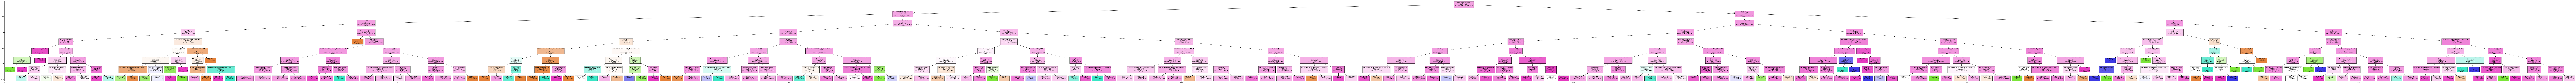

In [743]:
dot_data = StringIO()
filename = "reviewtree.png"
featureNames = df.columns[0:14]
targetNames = df['review_score'].unique().tolist()
out=tree.export_graphviz(reviewTree,feature_names=featureNames, out_file=dot_data, class_names= '12345', filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(400, 400))
plt.imshow(img,interpolation='nearest')